# CMSC 33750 HW4
## Lynn Zheng
## 11/7/20

Code files: (Note: `p#` stands for part `#` of the assignment)
- `hw4_eval.ipynb`: this notebook, contains visualization code and writeup
- `preprocess_data.py`: script for saving provided `normal-tumor, type-class` datat files to `.npy` files for faster loading
- `p1_generate_data.py`: generate data for part 1 for retraining the TC classifier
- `train.py`: training script for part 1, 2, 4; run using `train.py [p1|p2|p4]`
- `p4_preprocess_data.ipynb`: process `normal, tumor, metadata` data for training the classifier in part 4
- `p6_train.py`: Variational Autoencoder training script for part 6
- `train.sh, p6_train.sh`: slurm sbatch script
- `logs/`: model training logs

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [2]:
from train import load_data_concat_normal, construct_model
from p6_train import construct_vae

In [27]:
# plotting utils
def plot_confusion_matrix(cf_matrix, labels):
    ax = sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True labels')
    return ax

def plot_accu_loss(logfile):
    log = pd.read_csv(logfile)
    accu_df = log.melt('epoch', value_vars=['accuracy', 'val_accuracy'])
    loss_df = log.melt('epoch', value_vars=['loss', 'val_loss'])
    df = pd.concat([accu_df.assign(plot='accuracy'), loss_df.assign(plot='loss')])
    g = sns.FacetGrid(df, col='plot', hue='variable', sharey=False)
    g.map_dataframe(sns.lineplot, x='epoch', y='value')
    g.add_legend()
    plt.show()

# P1 Writeup
I used `type-class/tc1.autosave.model.h5` to generate tumor type classification labels for the tumor samples from the NT train and test dataset. (For the ease of data organization, I generated labels for the entire dataset, including tumor and normal, but only pulled out the tumor data for use.) I retrained the type classifier on `tc_train + tc_train_labels, nt_train + nt_train_tc_labels, nt_test + nt_test_tc_labels` (NT datasets with generated TC labels). I tested the model using `tc_test + tc_test_labels`.

Due to computation resource limitations, I could only train the model for 20 epochs. However, it still performed decently and achieved a test error of 0.136, and an accuracy of 0.97. 

From the confusion matrix below, the only prominent point of confusion is when the classifier recognizes 6 datapoints belonging to class 18 as class 17 and 5 datapoints from class 6 as class 35.

From the loss and accuracy plot below, we observe that the train and validation losses are steadily decreasing and the train and loss accuracy is steadily improving.

In [4]:
tc_test = np.load('data/tc_test.npy')
tc_test_labels = np.load('data/tc_test_labels.npy')

In [6]:
p1_model = construct_model(tc_test.shape[1], tc_test_labels.shape[1], 
                           weights='models/p1.autosave.model.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 60464, 128)        2688      
_________________________________________________________________
activation_5 (Activation)    (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 60464, 128)        0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60455, 128)        163968    
_________________________________________________________________
activation_6 (Activation)    (None, 60455, 128)        0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6045, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 773760)           

In [7]:
p1_score = p1_model.evaluate(tc_test, tc_test_labels, verbose=0)
p1_score

[0.13593116402626038, 0.970370352268219]

In [8]:
p1_probs = p1_model.predict(tc_test, verbose=0)

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

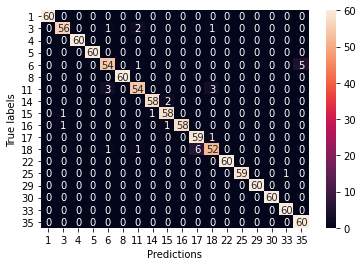

In [9]:
p1_preds = np.argmax(p1_probs, axis=1)
p1_true_labels = np.argmax(tc_test_labels, axis=1)
labels = np.union1d(np.unique(p1_preds), np.unique(p1_true_labels))
cf_matrix = confusion_matrix(p1_true_labels, p1_preds)
# although there are 36 classes in total in the code, 
# there are only 17 classes in the allocated tc_test data
plot_confusion_matrix(cf_matrix, labels)

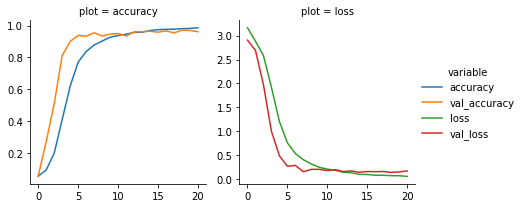

In [10]:
# epoch on the x-axis
plot_accu_loss('logs/p1.training.log')

# P2 Writeup
I added a new class to the existing `tc_labels`, resulting in a total of 37 classes (36 + normal, and the class index for normal is 36). I retrained the classifier on `tc_train` and normal samples from `nt_train`. I tested the model on `tc_test` and normal samples from `nt_test`.

Due to computation resource limitations, I could only train the model for 20 epochs. However, it still performed decently and achieved a test error of 0.107, and an accuracy of about 0.97. 

The confusion matrix below is similar to that in part 1, with some confusion among class (6, 8, 11), class (6, 35), and class (17, 18).

In the loss and accuracy plot below, we observe that the train and validation losses are steadily decreasing and the train and loss accuracy is steadily improving. Note that these metrics appear to have converged around the 10th epoch, which indicates that we could train for fewer epochs to avoid overfitting.

In [11]:
_, _, X_test, Y_test = load_data_concat_normal()

In [12]:
p2_model = construct_model(X_test.shape[1], Y_test.shape[1], 
                           weights='models/p2.autosave.model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 60464, 128)        2688      
_________________________________________________________________
activation_10 (Activation)   (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 60464, 128)        0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60455, 128)        163968    
_________________________________________________________________
activation_11 (Activation)   (None, 60455, 128)        0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 6045, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 773760)           

In [13]:
p2_score = p2_model.evaluate(X_test, Y_test, verbose=0)
p2_score

[0.1802012175321579, 0.9492647051811218]

In [14]:
p2_probs = p2_model.predict(X_test, verbose=0)

In [80]:
p2_preds = np.argmax(p2_probs, axis=1)
p2_true_labels = np.argmax(Y_test, axis=1)
labels = np.union1d(np.unique(p2_preds), np.unique(p2_true_labels))
cf_matrix = confusion_matrix(p2_true_labels, p2_preds)

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

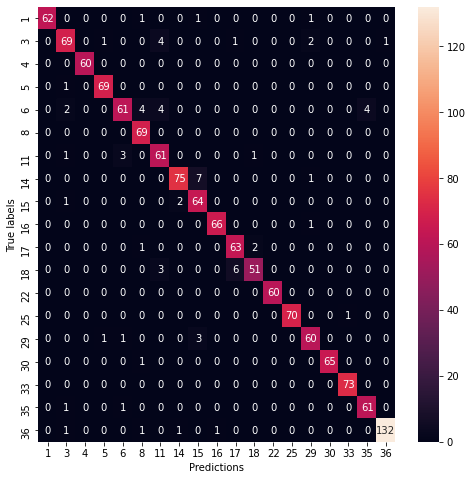

In [82]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cf_matrix, labels)

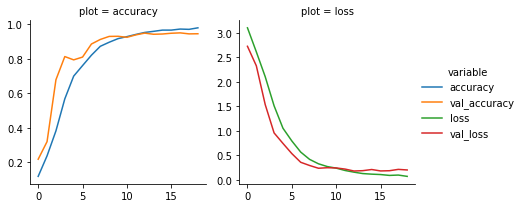

In [30]:
# epoch on the x-axis
plot_accu_loss('logs/p2.training.log')

# P3 Writeup

From my data partition construction in part 2, the model is trained on `tc_train` and `nt_train`, and has never seen `nt_test` during training. Hence for part 3 I used `nt_test` to test how many normal samples my classifier will wrongly classify. 

I tested the model on both normal and tumor data from `nt_test`. From the confusion matrix below, 4 normal samples are wrongly classified as tumor samples. A possible explanation is that these four samples have gene profiles that are similar to those of tumor samples.

The overall model accuracy is 0.98, which is fairly good.

In [31]:
nt_test = np.load('data/nt_test.npy')
nt_test_labels = np.load('data/nt_test_labels.npy')

In [32]:
p3_probs = p2_model.predict(nt_test, verbose=0)

In [76]:
p3_preds = np.argmax(p3_probs, axis=1)
# set tumor samples i.e. any label that is not 36 normal to 1 and normal 36 to 0
p3_preds[p3_preds != 36] = 1
p3_preds[p3_preds == 36] = 0
p3_true_labels = np.argmax(nt_test_labels, axis=1)
cf_matrix = confusion_matrix(p3_true_labels, p3_preds)

In [73]:
# number of misclassified normal samples
np.sum((p3_true_labels == 0) & (p3_preds != 0))

4

In [78]:
accuracy_score(p3_true_labels, p3_preds)

0.9821428571428571

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

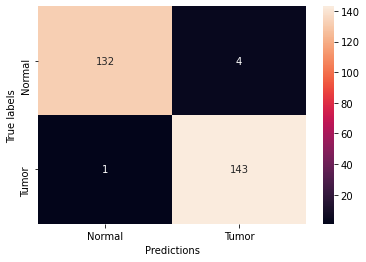

In [74]:
plot_confusion_matrix(cf_matrix, ['Normal', 'Tumor'])

# P4 Writeup

I read all the files from the `normal` and the `tumor` directories and matched their file names with the provided `metadata` file. I normalized the data using `MaxAbsScaler` as it is the scaler used for the NT and TC data in the provided neural network code. There are a total of 18 classes. This is a fairly small dataset with about 700 datapoints, so I reserved 600+ for training and 100 for testing.

One important thing to note about my implementation is that I used `sklearn`'s `OneHotEncoder`, which sorts the labels in ascending order. This is consistent with the behavior of `np.unique`, but not with `pd.Series.unique`.

The confusion matrix below doesn't show any significant trend of confusion between classes, so the model is pretty adequate. The loss and accuracy curves appear a little spiky and sporadic, which is possibly because our dataset was too small. I was worried that this model could easily overfit, but the testing results appear valid.

In [34]:
meta = pd.read_csv('data/metadata.csv')
# same ordering as sklearn.OneHotEncoder
tissue_types = np.unique(meta['tissue_type'])
tissue_types

array(['Adrenal Gland', 'Bile Duct', 'Bladder', 'Breast', 'Cervix',
       'Colorectal', 'Esophagus', 'Head and Neck', 'Kidney', 'Liver',
       'Lung', 'Pancreas', 'Prostate', 'Soft Tissue', 'Stomach', 'Thymus',
       'Thyroid', 'Uterus'], dtype=object)

In [35]:
p4_test = np.load('data/p4_test.npy')
p4_test_labels = np.load('data/p4_test_labels.npy')

In [36]:
p4_model = construct_model(p4_test.shape[1], p4_test_labels.shape[1], 
                           weights='models/p4.autosave.model.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 12806, 128)        2688      
_________________________________________________________________
activation_15 (Activation)   (None, 12806, 128)        0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12806, 128)        0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 12797, 128)        163968    
_________________________________________________________________
activation_16 (Activation)   (None, 12797, 128)        0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1279, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 163712)           

In [37]:
p4_score = p4_model.evaluate(p4_test, p4_test_labels, verbose=0)
p4_score

[0.0537816658616066, 0.9800000190734863]

In [38]:
p4_probs = p4_model.predict(p4_test, verbose=0)

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

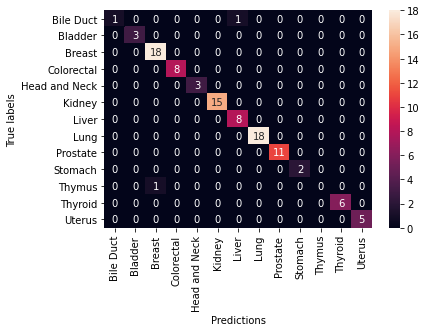

In [39]:
p4_preds = np.argmax(p4_probs, axis=1)
p4_true_labels = np.argmax(p4_test_labels, axis=1)
label_indices = np.union1d(np.unique(p4_preds), np.unique(p4_true_labels))
labels = tissue_types[label_indices]
cf_matrix = confusion_matrix(p4_true_labels, p4_preds)
plot_confusion_matrix(cf_matrix, labels)

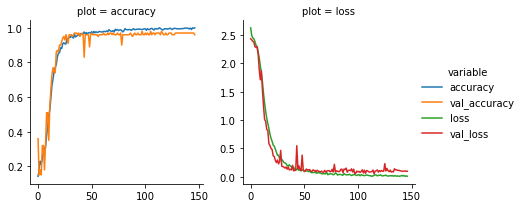

In [40]:
# epoch on the x-axis
plot_accu_loss('logs/p4.training.log')

# P5

I visualized a 2D plot with TSNE using both the training and testing data from part 4. Then I used KMeans to cluster the data and assign new type labels to them.

In [41]:
p4_train = np.load('data/p4_train.npy')
p4_train_labels = np.load('data/p4_train_labels.npy')
p5_train = np.concatenate([p4_train, p4_test]).squeeze()
p5_labels = np.concatenate([p4_train_labels, p4_test_labels])
p5_labels = np.argmax(p5_labels, axis=1)

To make TSNE run faster, first perform PCA.

In [42]:
temp = PCA(n_components=50).fit_transform(p5_train)
p5_emb_pca = TSNE(n_components=2, verbose=1).fit_transform(temp)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 726 samples in 0.005s...
[t-SNE] Computed neighbors for 726 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 726 / 726
[t-SNE] Mean sigma: 4.153277
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.156670
[t-SNE] KL divergence after 1000 iterations: 0.421434


<AxesSubplot:>

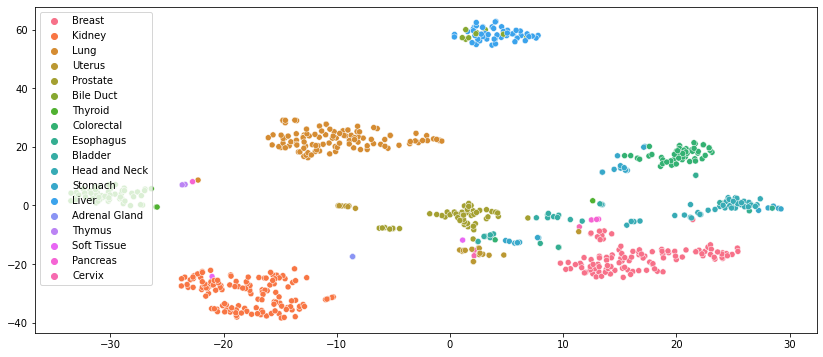

In [43]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=p5_emb_pca[:, 0], y=p5_emb_pca[:, 1],
                hue=tissue_types[p5_labels], legend='full')

Run TSNE without PCA

In [44]:
p5_emb_tse = TSNE(n_components=2, verbose=1).fit_transform(p5_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 726 samples in 0.912s...
[t-SNE] Computed neighbors for 726 samples in 17.860s...
[t-SNE] Computed conditional probabilities for sample 726 / 726
[t-SNE] Mean sigma: 4.331071
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.662403
[t-SNE] KL divergence after 1000 iterations: 0.456691


<AxesSubplot:>

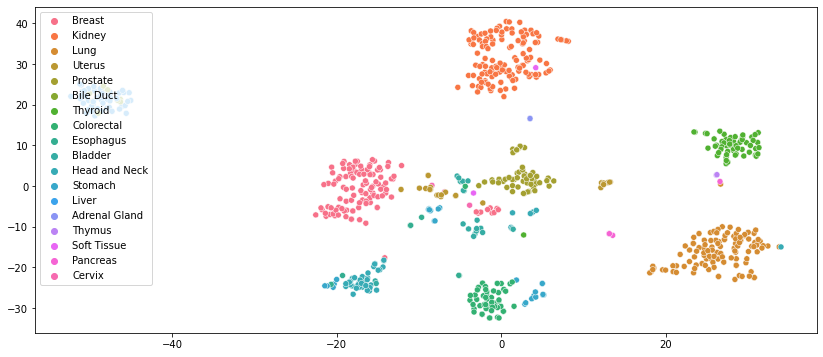

In [86]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=p5_emb_tse[:, 0], y=p5_emb_tse[:, 1],
                hue=tissue_types[p5_labels], legend='full')

We observe that the green dots and the marron dots are clustered together, so maybe Liver and Soft Tissue cancers are similar in some sense. There is also one big cluster to the left of the plot, covered by the legend. Let's use KMeans to see if we can reduce the number of labels. The experiemnt below show that four clusters produce pretty good visual separations for the clusters. 

In [46]:
p5_kmeans = KMeans(n_clusters=4).fit(p5_train)

<AxesSubplot:>

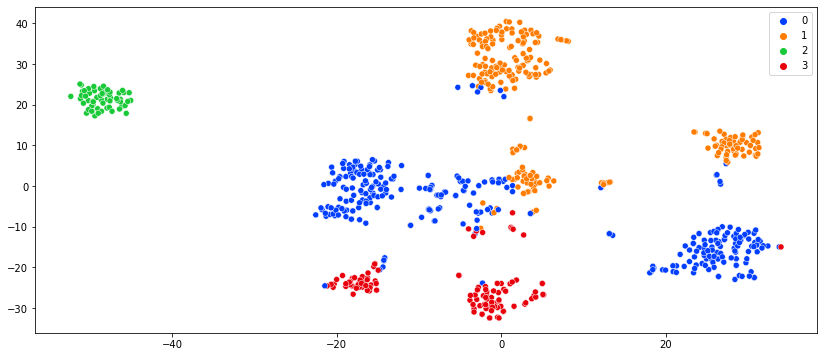

In [88]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=p5_emb_tse[:, 0], y=p5_emb_tse[:, 1],
                hue=p5_kmeans.labels_, legend='full',
               palette='bright')

In [48]:
# save the data for processing in p4_p5_preprocess_data.ipynb
# np.save('raw_data/p5_kmeans_labels', p5_kmeans.labels_)

In [49]:
p5_test_labels = np.load('data/p5_test_labels.npy')

In [50]:
p5_model = construct_model(p4_test.shape[1], p5_test_labels.shape[1], 
                           weights='models/p5.autosave.model.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 12806, 128)        2688      
_________________________________________________________________
activation_20 (Activation)   (None, 12806, 128)        0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 12806, 128)        0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12797, 128)        163968    
_________________________________________________________________
activation_21 (Activation)   (None, 12797, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1279, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 163712)           

In [51]:
p5_score = p5_model.evaluate(p4_test, p5_test_labels, verbose=0)
p5_score

[0.1413845717906952, 0.9800000190734863]

In [52]:
p5_probs = p5_model.predict(p4_test, verbose=0)

In [53]:
p5_preds = np.argmax(p5_probs, axis=1)
np.unique(p5_preds)

array([0, 1, 2, 3])

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

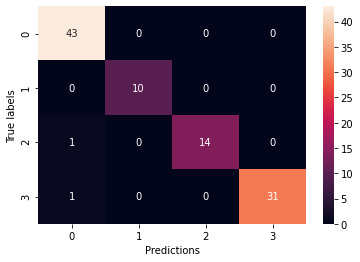

In [54]:
p5_true_labels = np.argmax(p5_test_labels, axis=1)
cf_matrix = confusion_matrix(p5_true_labels, p5_preds)
plot_confusion_matrix(cf_matrix, np.unique(p5_true_labels))

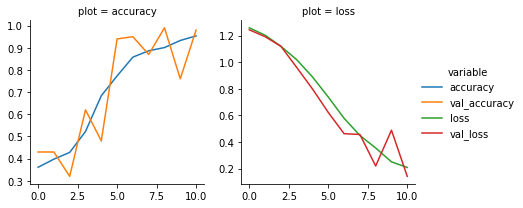

In [55]:
# epoch on the x-axis
plot_accu_loss('logs/p5.training.log')

# P5 Conclusion

With only four class labels, the model still performed decently in terms of loss and accuracy. I didn't ground my choice of classes in knowledge about biology (as I lack that background) but purely from my observation about the t-SNE clusters visualization. The fact that the model performed okay might mean that my choice of classes is at least somewhat valid in the sense that the classes are separable and learnable.

To avoid the potential problem of overfitting like in part 4 where I trained for over 100 epochs, I trained the model for only 10 epochs. We can observe from the loss and accuracy plots that the trend is pretty unstable due to our small data size.

# P6 Writeup
I trained a convolutional variational autoencoder following this [Keras blog post](https://keras.io/examples/generative/vae/). I trained the model using `nt_train`. My idea is that, when the VAE model is provided a normal sample from `nt_test`, it will produce a sample labelled normal, and similarly for a tumor sample. I trained it for 30 epochs. I could have trained it some more as it isn't very computationally intensive, but I was wary of overfitting especially because it's a generative model. This is especially evident from the KL-divergence plot below, which shows a very unstable trend in the KL-divergence. Generative models like VAEs and GANs are really difficult to train.

In [56]:
nt_test = np.load('data/nt_test.npy')
nt_test_labels = np.load('data/nt_test_labels.npy')

In [57]:
vae = construct_vae(latent_dim=2, num_features=nt_test.shape[1])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60483, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 30242, 32)    128         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 15121, 16)    1552        conv1d_10[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 241936)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [58]:
vae.encoder.load_weights('models/p6.encoder.model.h5')
vae.decoder.load_weights('models/p6.decoder.model.h5')

Produce normal samples and tumor samples using `nt_test`

In [59]:
test_normal_indices = (nt_test_labels[:, 1] == 0)
test_tumor_indices = (nt_test_labels[:, 1] == 1)
nt_test_normal = nt_test[test_normal_indices]
nt_test_tumor = nt_test[test_tumor_indices]

In [60]:
vae_sampled_normal = vae.decoder.predict(
    vae.encoder.predict(nt_test_normal)
)
vae_sampled_tumor = vae.decoder.predict(
    vae.encoder.predict(nt_test_tumor)
)

In [94]:
# generated 136 normal samples and 144 tumor samples
vae_sampled_normal.shape, vae_sampled_tumor.shape

((136, 60483, 1), (144, 60483, 1))

In [61]:
p6_test = np.concatenate([vae_sampled_normal, vae_sampled_tumor])
p6_test_labels = np.concatenate(
    [np.full(vae_sampled_normal.shape[0], fill_value=0),
     np.full(vae_sampled_tumor.shape[0], fill_value=1)
    ])

In [62]:
p6_probs = p2_model.predict(p6_test, verbose=0)

In [90]:
p6_preds = np.argmax(p6_probs, axis=1)
# like in part 3, set tumor samples i.e. any label that 
# is not 36 normal to 1 and normal 36 to 0
p6_preds[p6_preds != 36] = 1
p6_preds[p6_preds == 36] = 0
cf_matrix = confusion_matrix(p6_test_labels, p6_preds)

<AxesSubplot:xlabel='Predictions', ylabel='True labels'>

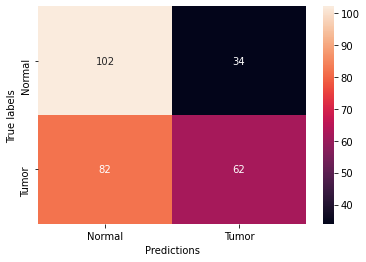

In [92]:
plot_confusion_matrix(cf_matrix, ['Normal', 'Tumor'])

From the confusion matrix above, assuming that our model from part 3 is adequate at separating normal and tumor samples, it appears that the VAE generator is fairly good at generating normal samples but not so good at generating tumor samples: In fact, 82 out of the 134 tumor samples it generated are recognized as normal by our type classifier from part 3.

In [95]:
log = pd.read_csv('logs/p6.training.log')


In [97]:
log.columns


Index(['epoch', 'kl_loss', 'loss', 'reconstruction_loss'], dtype='object')

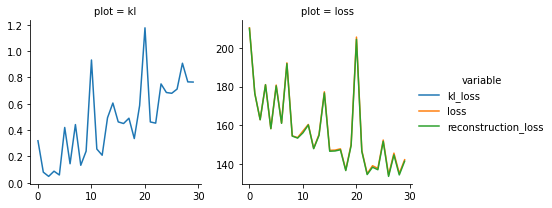

In [100]:
kl_df = log.melt('epoch', value_vars=['kl_loss'])
loss_df = log.melt('epoch', value_vars=['loss', 'reconstruction_loss'])
df = pd.concat([kl_df.assign(plot='kl'), loss_df.assign(plot='loss')])
g = sns.FacetGrid(df, col='plot', hue='variable', sharey=False)
g.map_dataframe(sns.lineplot, x='epoch', y='value')
g.add_legend()
plt.show()

As mentioned earlier, both the KL divergence plot and the loss plots are quite unstable. I chose to train the model for only 30 epochs because the VAE-MNIST example in the Keras documentation trained for only 30 epochs. WIth only 30 epochs, the model is pretty good at generating normal samples.